# Initialize Environment

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import numpy as np
import pandas as pd
# ensure kaggle api credentials available via .env
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import shutil
import plotnine as p9
import scipy.special as ssp

from information_theory.empirical_pmf import empirical_pmf

In [3]:
DATA_NEEDS_DOWNLOADED = False

# Extract Data

In [4]:
if DATA_NEEDS_DOWNLOADED:

    # expected workflow, though authentication issues persist
    # api = KaggleApi()
    # api.authenticate()
    # api.competition_download_file(
    #   "dont-get-kicked", "training.csv", path="./data/dont_get_kicked"
    # )

    os.system('kaggle competitions download -c DontGetKicked')
    shutil.unpack_archive("DontGetKicked.zip", "./data")
    os.remove("DontGetKicked.zip")

In [5]:
df_train = pd.read_csv("./data/training.csv")
df_test = pd.read_csv("./data/test.csv")

In [6]:
print(df_train.shape)
print(df_test.shape)

(72983, 34)
(48707, 33)


In [7]:
df_train.head().transpose()

,0,1,2,3,4
RefId,1,2,3,4,5
IsBadBuy,0,0,0,0,0
PurchDate,12/7/2009,12/7/2009,12/7/2009,12/7/2009,12/7/2009
Auction,ADESA,ADESA,ADESA,ADESA,ADESA
VehYear,2006,2004,2005,2004,2005
VehicleAge,3,5,4,5,4
Make,MAZDA,DODGE,DODGE,DODGE,FORD
Model,MAZDA3,1500 RAM PICKUP 2WD,STRATUS V6,NEON,FOCUS
Trim,i,ST,SXT,SXT,ZX3
SubModel,4D SEDAN I,QUAD CAB 4.7L SLT,4D SEDAN SXT FFV,4D SEDAN,2D COUPE ZX3


# Analyze: Discrete-Valued

## Visualize (Intuition)

In [8]:
df_train['Make'] = df_train["Make"].fillna('NULL')
df_test['Make'] = df_test["Make"].fillna('NULL')

In [9]:
x_q = df_train['Make']
n_q = df_train.shape[0]

x_p = df_test['Make']
n_p = df_test.shape[0]

In [10]:
q = empirical_pmf(x_q.copy(), 10, include_other=True)
q['series'] = 'Historical'

In [11]:
p = empirical_pmf(
    x_p.copy(), 10, categories=list(q['Make']), include_other=True
    )
p['series'] = 'Test'

In [12]:
compare_p_q = pd.concat([p, q], axis=0)
compare_p_q = compare_p_q.rename(columns={'Make': 'bin'})

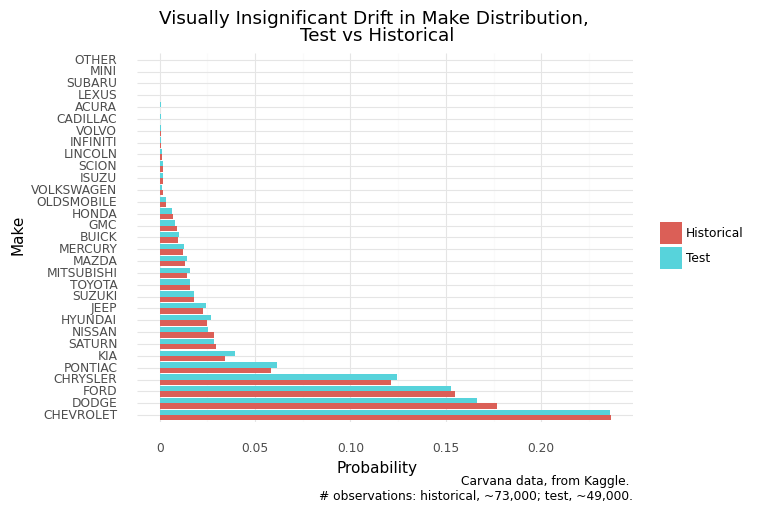

<ggplot: (8728488803350)>

In [13]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(y = "Probability", x = "Make", fill='',
            title=(
                "Visually Insignificant Drift in Make Distribution, \n" +
                "Test vs Historical"
            ),
            caption = (
                "Carvana data, from Kaggle. \n" + 
                "# observations: historical, ~73,000; test, ~49,000."
            )) + 
    p9.coord_flip()
)

## Statistical Tests

In [14]:
# prefer to align by index, in separate namespaces, for less data manipulation
p = p.set_index('Make')
q = q.set_index("Make")
p = p.loc[q.index]

In [15]:
# confirm, selection-by-index does not drop any pmf elements
p['prb'].sum()

0.9999999999999999

In [16]:
kl_div_point = ssp.rel_entr(p["prb"], q["prb"]).sum()
kl_div_point

0.0017738206029620908

In [17]:
def bootstrap_draw_kl_divergence(x_q, nobs_test_set, nobs_lt_pool_other):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    bootstrap sample one test set draw, then compute KL Divergence.

    q is unknown and estimable: has generated observations `x_q`.
    """

    var = x_q.name

    q = empirical_pmf(
        x_q, nobs_lt_pool_other, categories=[], include_other=True
        )

    x_p_sample = pd.Series(
        np.random.choice(x_q, size=nobs_test_set, replace=True), name=var
    )
    p = empirical_pmf(
        x_p_sample, nobs_lt_pool_other, 
        categories=list(q[var]), include_other=True
        )
    
    p = p.set_index(var)
    q = q.set_index(var)
    p = p.loc[q.index]

    kl_div = ssp.rel_entr(p["prb"], q["prb"]).sum()

    return {'p': p, 'q': q, 'kl_divergence': kl_div}

In [18]:
def bootstrap_sampling_distr_kl_divergence(
        x_q, nobs_test_set, nobs_lt_pool_other, n_draws
        ):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    simulate sampling distribution of KL Divergence value.

    q is unknown and estimable: has generated observations `x_q`.

    When a new observations test set does truly generate from
    population probability distribution q, 
    KL Divergence sampling variation partly controlled by:
        - Test set sample size (small sample size, wider variation)

    """

    kl_div_draws = [
        bootstrap_draw_kl_divergence(x_q, nobs_test_set, nobs_lt_pool_other)
        for i in range(n_draws)
    ]

    kl_div_values = [x['kl_divergence'] for x in kl_div_draws]
    idx_sort = np.argsort(kl_div_values)
    kl_div_draws = [kl_div_draws[i] for i in idx_sort]

    return kl_div_draws


In [19]:
N_SAMPLING_DISTR_DRAWS = 1000

### Naive

In [20]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q.copy(), nobs_test_set=df_test.shape[0], 
    nobs_lt_pool_other=10, n_draws=N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

In [21]:
kl_div_distr0[0]

{'p':                 n       prb
 Make                       
 CHEVROLET   11597  0.238097
 DODGE        8561  0.175765
 FORD         7632  0.156692
 CHRYSLER     5837  0.119839
 PONTIAC      2795  0.057384
 KIA          1612  0.033096
 SATURN       1434  0.029441
 NISSAN       1422  0.029195
 HYUNDAI      1181  0.024247
 JEEP         1078  0.022132
 SUZUKI        872  0.017903
 TOYOTA        768  0.015768
 MITSUBISHI    698  0.014331
 MAZDA         685  0.014064
 MERCURY       610  0.012524
 BUICK         487  0.009999
 GMC           432  0.008869
 HONDA         357  0.007330
 OLDSMOBILE    160  0.003285
 VOLKSWAGEN     94  0.001930
 ISUZU          84  0.001725
 SCION          92  0.001889
 LINCOLN        65  0.001335
 INFINITI       29  0.000595
 VOLVO          24  0.000493
 CADILLAC       22  0.000452
 ACURA          24  0.000493
 LEXUS          21  0.000431
 SUBARU         18  0.000370
 MINI           13  0.000267
 OTHER           3  0.000062,
 'q':                 n       prb
 Ma

In [22]:
sum(np.array(kl_div_distr) > kl_div_point)

0

In [23]:
np.quantile(kl_div_distr, q = [0.1, 0.25, 0.5, 0.75, 0.9])

array([0.00021738, 0.00025635, 0.00030886, 0.00036634, 0.00044047])

In [24]:
df_p = kl_div_distr0[999]['p'].reset_index(drop=False)
df_p['series'] = 'Extreme Test Draw (49K Obs) from Historical'

df_q = kl_div_distr0[999]['q'].reset_index(drop=False)
df_q['series'] = 'Historical'

compare_p_q = pd.concat([df_p, df_q], axis=0)

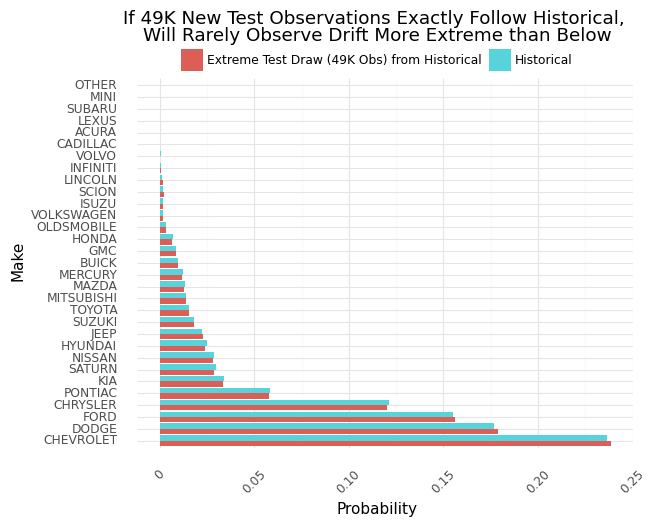

<ggplot: (8728487843316)>

In [25]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('Make', 'prb', fill='series'), position='dodge') + 
    p9.labs(
        y = "Probability", x = "Make", fill='',
        title = (
            "If 49K New Test Observations Exactly Follow Historical, \n" +
            "Will Rarely Observe Drift More Extreme than Below"
        )
    ) + 
    # ensure sufficient white space between title, legend, plot area
    p9.theme(legend_position='top', 
             legend_box_spacing=-.1,
             plot_title=p9.element_text(margin={'b': 25}),
             axis_text_x=p9.element_text(angle=45)) + 
    p9.coord_flip()
)

### Calibrated

In [26]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q.copy(), nobs_test_set=100, 
    nobs_lt_pool_other=1, n_draws=N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

sum(np.array(kl_div_distr) > kl_div_point)

1000

In [27]:
df_p = kl_div_distr0[950]['p'].reset_index(drop=False)
df_p['series'] = 'Extreme Test Draw (100 Obs) from Historical'

df_q = kl_div_distr0[950]['q'].reset_index(drop=False)
df_q['series'] = 'Historical'

compare_p_q = pd.concat([df_p, df_q], axis=0)

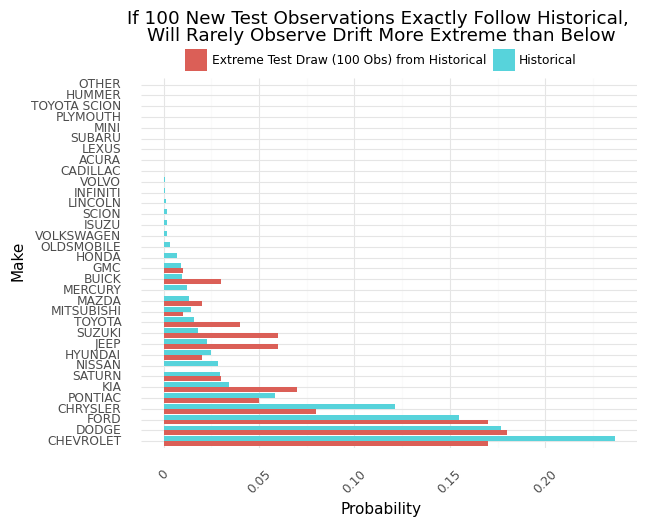

<ggplot: (8728488640395)>

In [28]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('Make', 'prb', fill='series'), position='dodge') + 
    p9.labs(
        y = "Probability", x = "Make", fill='',
        title = (
            "If 100 New Test Observations Exactly Follow Historical, \n" +
            "Will Rarely Observe Drift More Extreme than Below"
        )
    ) + 
    # ensure sufficient white space between title, legend, plot area
    p9.theme(legend_position='top', 
             legend_box_spacing=-.1,
             plot_title=p9.element_text(margin={'b': 25}),
             axis_text_x=p9.element_text(angle=45)) + 
    p9.coord_flip()
)

# Supplemental

# Analyze: Continuous-Valued

## Visualize (Intuition)

In [29]:
print(df_train['VehOdo'].isnull().sum())
print(df_test['VehOdo'].isnull().sum())

0
0


In [30]:
x_q = df_train['VehOdo']
n_q = df_train.shape[0]

x_p = df_test['VehOdo']
n_p = df_test.shape[0]

In [31]:
N_BINS = 10

In [32]:
q = np.histogram(x_q, bins=N_BINS)
q

(array([   22,   145,   919,  5050, 10124, 16298, 22200, 15243,  2807,
          175]),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [33]:
def format_histogram_bin_labels(hist_output):
    """
    Intake np.histogram output directly, or subset bin edges.
    Formatting tailored for magnitudes in 10,000s, 100,000s.
    """
    
    if type(hist_output) == tuple:
        bin_edges = hist_output[1]
    else:
        bin_edges = hist_output

    labels = [
        str(i) + ": " + "[" + f"{bin_edges[i]:,.0f}" + ", " + 
        f"{bin_edges[i+1]:,.0f}" + ")" 
        for i in range(bin_edges.shape[0]-1)
        ]
    # last bin closed on both sides
    labels[-1] = labels[-1].replace(")", "]")
    
    return labels


In [34]:
bin_labels = format_histogram_bin_labels(q)

In [35]:
bin_labels

['0: [4,825, 15,914)',
 '1: [15,914, 27,003)',
 '2: [27,003, 38,093)',
 '3: [38,093, 49,182)',
 '4: [49,182, 60,271)',
 '5: [60,271, 71,360)',
 '6: [71,360, 82,449)',
 '7: [82,449, 93,539)',
 '8: [93,539, 104,628)',
 '9: [104,628, 115,717]']

In [36]:
df_q = pd.DataFrame({
    'n': q[0],
    'prb': q[0] / n_q,
    'series': 'Historical'
})
df_q['bin'] = bin_labels

In [37]:
p = np.histogram(x_p, bins=q[1])

In [38]:
p

(array([   29,   121,   672,  3203,  6433, 11176, 14937, 10334,  1672,
          126]),
 array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]))

In [39]:
df_p = pd.DataFrame({
    'n': p[0],
    'prb': p[0] / n_p,
    'series': 'Test'
})
df_p['bin'] = bin_labels

In [40]:
compare_p_q = pd.concat([df_q, df_p], axis=0)

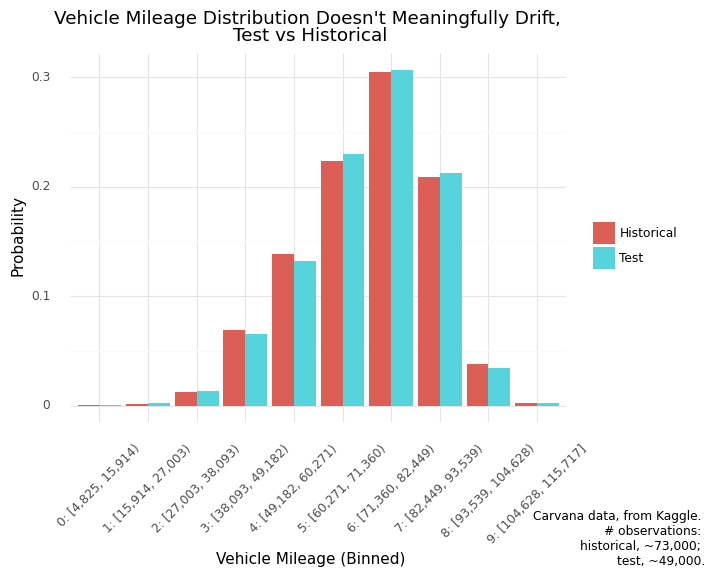

<ggplot: (8728488287865)>

In [41]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(y = "Probability", x = "Vehicle Mileage (Binned)", fill='',
            title=(
                "Vehicle Mileage Distribution Doesn't Meaningfully Drift, \n" +
                "Test vs Historical"
            ),
            caption = (
                "Carvana data, from Kaggle. \n" + 
                "# observations: \nhistorical, ~73,000; \ntest, ~49,000."
            )) + 
    p9.theme(
        axis_text_x=p9.element_text(angle=45), 
        plot_caption=p9.element_text(margin={'r': -100, 't': 25}),
        )
)

## Statistical Tests

In [42]:
kl_div_point = ssp.rel_entr(p[0] / n_p, q[0] / n_q).sum()
kl_div_point

0.0007486716020464318

In [43]:
def bootstrap_draw_kl_divergence(x_q, n_bins, nobs_test_set):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    bootstrap sample one test set draw, then compute KL Divergence.

    q is unknown and estimable:
        - Has generated observations `x_q`
        - Estimated by discrete pmf with `n_bins`
    """

    q_hist = np.histogram(x_q, bins=n_bins)
    n_q = q_hist[0].sum()

    x_p_sample = np.random.choice(x_q, size=nobs_test_set, replace=True)
    p_hist = np.histogram(x_p_sample, bins=q_hist[1])

    q_hat = q_hist[0] / n_q
    p_hat = p_hist[0] / nobs_test_set

    kl_div = ssp.rel_entr(p_hat, q_hat).sum()

    out = {
        'p': p_hat, 'n_p': nobs_test_set, 
        'q': q_hat, 'bins': q_hist[1], 
        'kl_divergence': kl_div
        }

    return out

In [44]:
def bootstrap_sampling_distr_kl_divergence(x_q, n_bins, nobs_test_set, n_draws):
    """
    Under the (null) condition that 
    a new observations test set generates from 
    the baseline population probability distribution q:
    simulate sampling distribution of KL Divergence value.

    q is unknown and estimable:
        - Has generated observations `x_q`
        - Estimated by discrete pmf with `n_bins`

    When a new observations test set does truly generate from
    population probability distribution q, 
    KL Divergence sampling variation partly controlled by:
        - Test set sample size (small sample size, wider variation)
        - Probability distribution q estimate precision 
        (more discretized bins, wider variation) 

    """

    kl_div_draws = [
        bootstrap_draw_kl_divergence(x_q, n_bins, nobs_test_set)
        for i in range(n_draws)
    ]

    kl_div_values = [x['kl_divergence'] for x in kl_div_draws]
    idx_sort = np.argsort(kl_div_values)
    kl_div_draws = [kl_div_draws[i] for i in idx_sort]

    return kl_div_draws


In [45]:
N_SAMPLING_DISTR_DRAWS = 1000

### Naive

In [46]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, df_test.shape[0], N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

In [47]:
kl_div_distr0[0]

{'p': array([0.00030796, 0.00192991, 0.01260599, 0.06955879, 0.13895333,
        0.22282218, 0.30484325, 0.20773195, 0.03890611, 0.00234053]),
 'n_p': 48707,
 'q': array([3.01440061e-04, 1.98676404e-03, 1.25919735e-02, 6.91941959e-02,
        1.38717236e-01, 2.23312278e-01, 3.04180426e-01, 2.08856857e-01,
        3.84610115e-02, 2.39781867e-03]),
 'bins': array([  4825. ,  15914.2,  27003.4,  38092.6,  49181.8,  60271. ,
         71360.2,  82449.4,  93538.6, 104627.8, 115717. ]),
 'kl_divergence': 9.609296915332885e-06}

In [48]:
sum(np.array(kl_div_distr) > kl_div_point)

0

In [49]:
np.quantile(kl_div_distr, q = [0.1, 0.25, 0.5, 0.75, 0.9])

array([4.25561953e-05, 6.11319456e-05, 8.42176195e-05, 1.15824469e-04,
       1.51839641e-04])

In [50]:
# delta = [kl_div_distr[i] - kl_div_distr[i-1] for i in range(1, len(kl_div_distr))]
# sum(np.array(delta) < 0)

In [51]:
df_p = pd.DataFrame({
    'prb': kl_div_distr0[999]['p'], 'series': 'Extreme Test Draw (49K Obs) from Historical'
    })
df_p['bin'] = format_histogram_bin_labels(kl_div_distr0[0]['bins'])

df_q = pd.DataFrame({'prb': kl_div_distr0[999]['q'], 'series': 'Historical'})
df_q['bin'] = format_histogram_bin_labels(kl_div_distr0[1]['bins'])

compare_p_q = pd.concat([df_p, df_q], axis=0)

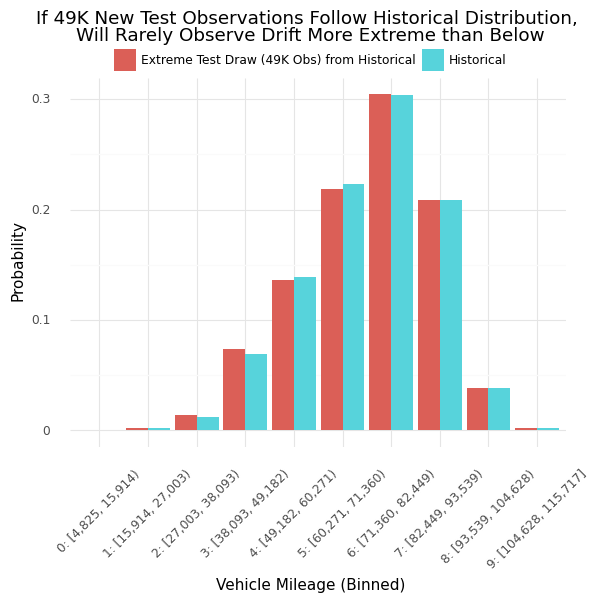

<ggplot: (8728484870163)>

In [52]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(
        y = "Probability", x = "Vehicle Mileage (Binned)", fill='',
        title = (
            "If 49K New Test Observations Follow Historical Distribution, \n" +
            "Will Rarely Observe Drift More Extreme than Below"
        )
    ) + 
    # ensure sufficient white space between title, legend, plot area
    p9.theme(legend_position='top', 
             legend_box_spacing=-.1,
             plot_title=p9.element_text(margin={'b': 25}),
             axis_text_x=p9.element_text(angle=45))
)

### Calibrated

In [53]:
kl_div_distr0 = bootstrap_sampling_distr_kl_divergence(
    x_q, N_BINS, 100, N_SAMPLING_DISTR_DRAWS
    )
kl_div_distr = [x['kl_divergence'] for x in kl_div_distr0]

sum(np.array(kl_div_distr) > kl_div_point)

1000

In [54]:
df_p = pd.DataFrame({
    'prb': kl_div_distr0[999]['p'], 'series': 'Extreme Test Draw (100 Obs) from Historical'
    })
df_p['bin'] = format_histogram_bin_labels(kl_div_distr0[0]['bins'])

df_q = pd.DataFrame({'prb': kl_div_distr0[999]['q'], 'series': 'Historical'})
df_q['bin'] = format_histogram_bin_labels(kl_div_distr0[1]['bins'])

compare_p_q = pd.concat([df_p, df_q], axis=0)

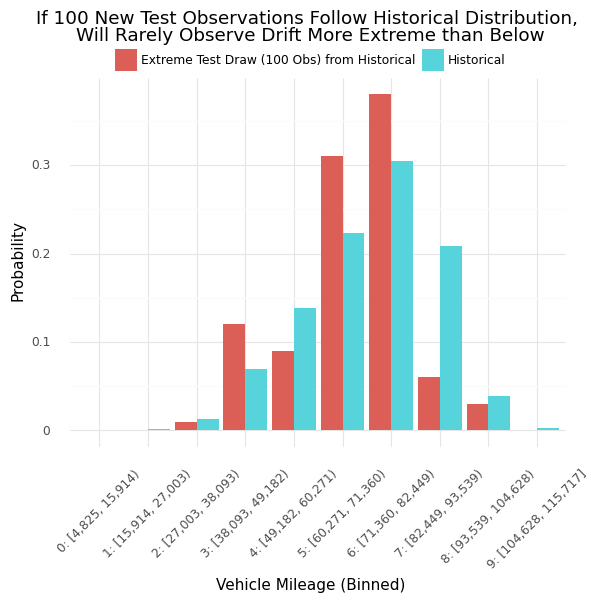

<ggplot: (8728487863546)>

In [55]:
(
    p9.ggplot(compare_p_q) + 
    p9.theme_minimal() + 
    p9.geom_col(p9.aes('bin', 'prb', fill='series'), position='dodge') + 
    p9.labs(
        y = "Probability", x = "Vehicle Mileage (Binned)", fill='',
        title = (
            "If 100 New Test Observations Follow Historical Distribution, \n" +
            "Will Rarely Observe Drift More Extreme than Below"
        )
    ) + 
    # ensure sufficient white space between title, legend, plot area
    p9.theme(legend_position='top', 
             legend_box_spacing=-.1,
             plot_title=p9.element_text(margin={'b': 25}),
             axis_text_x=p9.element_text(angle=45))
)